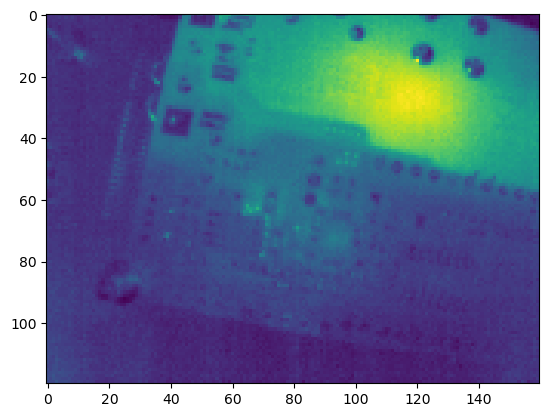

(120, 160)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# .npy 파일을 NumPy 배열로 읽기
arr = np.load('3.개방데이터/1.데이터/1.Training/1.원천데이터/agv/01/agv01_0901_0812/agv01_0901_081240.bin')

# 결과 출력
plt.figure()
plt.imshow(arr)
plt.show()
print(arr.shape)

In [3]:
import joblib
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# 전체 모델 및 이하 모델의 모듈

In [4]:
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim, patch_size, embed_dim, num_heads, depth):
        super().__init__()
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True
        )
        self.patch_embed = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, (img_dim // patch_size) ** 2, embed_dim))

    def forward(self, x):
        # x: [batch_size, 3, img_dim, img_dim]
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        return x.mean(dim=1)  # [batch_size, embed_dim]

class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, aux_data):
        return self.fc(aux_data)

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, query, key):
        attn_output, _ = self.attention(query, key, key)
        return attn_output

class ConditionClassifier(nn.Module):
    def __init__(self, img_dim, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes):
        super().__init__()
        self.vit = ViTFeatureExtractor(img_dim, patch_size, embed_dim, num_heads, depth)
        self.soft_label_encoder = SoftLabelEncoder(aux_input_dim, embed_dim)
        self.cross_attention = CrossAttention(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, images, aux_data):
        # Feature extraction
        visual_features = self.vit(images)  # [batch_size, embed_dim]
        print(visual_features.shape)
        aux_features = self.soft_label_encoder(aux_data)  # [batch_size, embed_dim]
        print(aux_features.shape)

        # Cross attention
        visual_features = visual_features.unsqueeze(1)  # [batch_size, 1, embed_dim]
        print(visual_features.shape)
        aux_features = aux_features.unsqueeze(1)  # [batch_size, 1, embed_dim]
        print(aux_features.shape)
        integrated_features = self.cross_attention(visual_features, aux_features).squeeze(1)

        # Classification
        output = self.classifier(integrated_features)  # [batch_size, num_classes]
        return F.softmax(output, dim=1)

# 하이퍼파라미터 정의
img_dim = 224
patch_size = 16
embed_dim = 132
num_heads = 4
depth = 7
aux_input_dim = 11  # 보조 데이터 차원 (예: 온도, 습도 등)
num_classes = 4  # 0:정상,1:관심,2:주의,3:위험

# 모델 생성
model = ConditionClassifier(img_dim, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes)

# 예제 입력
images = torch.randn(30, 3, img_dim, img_dim)  # [batch_size, channels, height, width]
aux_data = torch.randn(30, aux_input_dim)  # [batch_size, aux_input_dim]

# Forward pass
output = model(images, aux_data)

torch.Size([30, 132])
torch.Size([30, 132])
torch.Size([30, 1, 132])
torch.Size([30, 1, 132])


# 모듈 검사하나 하나 검사하기

## VIT가 열화상 이미지[1,width,height]가 적용이 될 수 있을까요?

In [5]:
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth):
        super().__init__()
        # Transformer 설정
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True
        )
        # Patch embedding: 채널을 1로 설정
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        # 포지셔널 임베딩
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        # x: [batch_size, 1, img_dim_h, img_dim_w]
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding  # Positional embedding 추가
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        return x.mean(dim=1)  # [batch_size, embed_dim]

agv_img_files = joblib.load('oht_dataframe.pkl')[['filenames','state']]
width,height = np.load(agv_img_files.loc[0]['filenames']).shape
image = torch.tensor(np.load(agv_img_files.loc[0]['filenames']),dtype=torch.float32).unsqueeze(0).unsqueeze(0)
image1 = torch.tensor(np.load(agv_img_files.loc[1]['filenames']),dtype=torch.float32).unsqueeze(0).unsqueeze(0)
image = torch.concat([image,image1],axis=0) # 2개의 이미지 데이터를 가져와서 concat함

print(image.shape) # 우리의 데이터는 열화상 이미지(흑백)이므로 위에서 ViTFeatureExtractor 모델 구조를 변경해야함함

# 모델 생성 예시
img_dim_h = 120  # 열화상 이미지 세로 크기
img_dim_w = 160  # 열화상 이미지 가로 크기
patch_size = 16
embed_dim = 128
num_heads = 4
depth = 6

model = ViTFeatureExtractor(height, width, patch_size, embed_dim, num_heads, depth) # 입력 이미지 [batch_size, 1, img_dim_h, img_dim_w]
output1 = model(image)
print(output1.shape) # 이미지 특징 벡터 (batch_size, embeding_dim)

torch.Size([2, 1, 120, 160])
torch.Size([2, 128])


- 입력 열화상 이미지 [batch_size, 1, 가로, 세로] -> [batch_size, embed_dim] 으로 특징벡터 출력

- 입력 이미지 크기 [2,1,120,160] -> [2,128] 특징벡터

## SoftLabelEncoder가 내 Tabular 데이터를 읽어 올 수 있을까요?

In [6]:
class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, aux_data):
        return self.fc(aux_data)

tabular = joblib.load('agv_dataframe.pkl')
tabular = tabular.drop(columns='filenames')

X,y = tabular.drop(columns='state'),tabular['state']
aux_input_dim = X.shape[1]
embed_dim =128
model = SoftLabelEncoder(aux_input_dim,embed_dim)
output2 = model(torch.tensor(X.values[:2],dtype=torch.float32))

print(output2.shape)

torch.Size([2, 128])


- 입력 데이터: [행의 개수 * dataset의 columns 개수] -> [행의 개수 * embed_dim]

- 위에서는 2개 이미지를 사용했으니 이미지와 일치하는 센서 데이터를 2개를 가져와서 모델 통과 시켜보는 실험

- 센서 데이터 11개 칼럼 -> SoftLabelEncoder -> 특징벡터 [2, 128]로 출력

## CrossAttention: 서로 다른 데이터로 부터 나온 특징 벡터 (이미지, 센서 데이터)간의 연관성을 찾아주는 모듈

In [7]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, query, key):
        attn_output, _ = self.attention(query, key, key)
        return attn_output
    
visual_features = output1.unsqueeze(1)  # [batch_size, 1, embed_dim]
aux_features = output2.unsqueeze(1)  # [batch_size, 1, embed_dim]
cross_attention = CrossAttention(embed_dim,num_heads)
integrated_features = cross_attention(visual_features, aux_features).squeeze(1)
integrated_features.shape # 두 특징 벡터를 조합하여 하나의 통합된 특징 벡터로 변환

torch.Size([2, 128])

- 이미지 특징 벡터 [2,128] + 센서 특징 벡터 [2,128] = 통합된 특징 벡터 [2,128]

- 통합 가능

In [8]:
classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, num_classes)
        )
torch.argmax(F.softmax(classifier(integrated_features),dim=1),dim=1) # Softmax 확률화 및 가장 높은 확률의 Index 찾기

tensor([0, 0])

- 통합 특징 벡터 [2,128] 을 [2,1]로 정답 예측 벡터로 변환

# 최종 모델 구조

In [11]:
class ViTFeatureExtractor(nn.Module):
    def __init__(self, img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth):
        super().__init__()
        # Transformer 설정
        self.vit = nn.Transformer(
            d_model=embed_dim,
            nhead=num_heads,
            num_encoder_layers=depth,
            batch_first=True
        )
        # Patch embedding: 채널을 1로 설정
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        # 포지셔널 임베딩
        num_patches = (img_dim_h // patch_size) * (img_dim_w // patch_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))

    def forward(self, x):
        # x: [batch_size, 1, img_dim_h, img_dim_w]
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]
        x = patches + self.pos_embedding  # Positional embedding 추가
        x = self.vit(x, x)  # [batch_size, num_patches, embed_dim]
        return x.mean(dim=1)  # [batch_size, embed_dim]

class SoftLabelEncoder(nn.Module):
    def __init__(self, aux_input_dim, embed_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(aux_input_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, aux_data):
        return self.fc(aux_data)

class CrossAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, query, key):
        attn_output, _ = self.attention(query, key, key)
        return attn_output

class ConditionClassifier(nn.Module):
    def __init__(self, img_dim_h,img_dim_w, patch_size, embed_dim, num_heads, depth, aux_input_dim, num_classes):
        super().__init__()
        self.vit = ViTFeatureExtractor(img_dim_h, img_dim_w, patch_size, embed_dim, num_heads, depth)
        self.soft_label_encoder = SoftLabelEncoder(aux_input_dim, embed_dim)
        self.cross_attention = CrossAttention(embed_dim, num_heads)
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, num_classes)
        )

    def forward(self, images, aux_data):
        # Feature extraction
        visual_features = self.vit(images)  # [batch_size, embed_dim]
        print(visual_features.shape)
        aux_features = self.soft_label_encoder(aux_data)  # [batch_size, embed_dim]
        print(aux_features.shape)

        # Cross attention
        visual_features = visual_features.unsqueeze(1)  # [batch_size, 1, embed_dim]
        print(visual_features.shape)
        aux_features = aux_features.unsqueeze(1)  # [batch_size, 1, embed_dim]
        print(aux_features.shape)
        integrated_features = self.cross_attention(visual_features, aux_features).squeeze(1)

        # Classification
        output = self.classifier(integrated_features)  # [batch_size, num_classes]
        return F.softmax(output, dim=1)

img_dim_h = 120  # 열화상 이미지 세로 크기
img_dim_w = 160  # 열화상 이미지 가로 크기
patch_size = 16
embed_dim = 128
num_heads = 4
depth = 6
aux_input_dim = 11  # 보조 데이터 차원 (예: 온도, 습도 등)
num_classes = 4  # 0:정상,1:관심,2:주의,3:위험

model = ConditionClassifier(img_dim_w,img_dim_h,patch_size,embed_dim,num_heads,depth,aux_input_dim,num_classes)
model(image,torch.tensor(X.values[:2],dtype=torch.float32))

torch.Size([2, 128])
torch.Size([2, 128])
torch.Size([2, 1, 128])
torch.Size([2, 1, 128])


tensor([[0.1054, 0.6364, 0.1356, 0.1226],
        [0.1088, 0.6341, 0.1311, 0.1260]], grad_fn=<SoftmaxBackward0>)